In [1]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [6]:
####
import json
import numpy as np

# 读取数据函数
def load_data(filename):
    with open(filename, "r", encoding="utf-8") as file:
        data = json.load(file)
    seq_1 = [seq["seq_1"] for seq in data]
    seq_2 = [seq["seq_2"] for seq in data]
    labels = [seq["label"] for seq in data]
    return seq_1, seq_2, labels

# 加载数据
train_seq_1, train_seq_2, train_labels = load_data("hppi_train.json")
valid_seq_1, valid_seq_2, valid_labels = load_data("hppi_valid.json")
test_seq_1, test_seq_2, test_labels = load_data("hppi_test.json")

vocab_size = 401
max_length = 256


In [7]:
import random

# 将10%的训练数据划分为测试集和验证集
def split_data(train_seq_1, train_seq_2, train_labels):
    # 确定10%的数据量
    split_size = int(0.1 * len(train_seq_1))

    # 生成测试集和验证集的索引
    indices = list(range(len(train_seq_1)))
    random.shuffle(indices)
    test_indices = indices[:split_size]
    valid_indices = indices[split_size:2*split_size]

    # 初始化测试集和验证集
    test_seq_1 = [train_seq_1[i] for i in test_indices]
    test_seq_2 = [train_seq_2[i] for i in test_indices]
    test_labels = [train_labels[i] for i in test_indices]

    valid_seq_1 = [train_seq_1[i] for i in valid_indices]
    valid_seq_2 = [train_seq_2[i] for i in valid_indices]
    valid_labels = [train_labels[i] for i in valid_indices]

    # 从训练集中移除测试集和验证集的样本
    train_seq_1 = [train_seq_1[i] for i in range(len(train_seq_1)) if i not in test_indices and i not in valid_indices]
    train_seq_2 = [train_seq_2[i] for i in range(len(train_seq_2)) if i not in test_indices and i not in valid_indices]
    train_labels = [train_labels[i] for i in range(len(train_labels)) if i not in test_indices and i not in valid_indices]

    return train_seq_1, train_seq_2, train_labels, valid_seq_1, valid_seq_2, valid_labels, test_seq_1, test_seq_2, test_labels

# 划分数据集
train_seq_1, train_seq_2, train_labels, valid_seq_1, valid_seq_2, valid_labels, test_seq_1, test_seq_2, test_labels = split_data(train_seq_1, train_seq_2, train_labels)

# 打印各个数据集的大小
print("训练集大小:", len(train_seq_1))
print("验证集大小:", len(valid_seq_1))
print("测试集大小:", len(test_seq_1))


训练集大小: 18476
验证集大小: 2309
测试集大小: 2309


In [8]:
from collections import Counter

def count_kmer(seq, k):
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    return Counter(kmers)

# 统计训练集中 k-mer=2 的出现频率，并按频率顺序构建字典
train_kmer_counts = Counter()
for seq in train_seq_1 + train_seq_2:
    train_kmer_counts += count_kmer(seq, k=2)

sorted_train_kmer_counts = sorted(train_kmer_counts.items(), key=lambda x: x[1], reverse=True)

# 构建字典，将每个蛋白质映射到一个索引值
protein_dict = {protein: idx + 1 for idx, (protein, _) in enumerate(sorted_train_kmer_counts)}

# 编码函数，将蛋白质序列转换为编码序列
def encode_sequence(seq):
    encoded_seq = [protein_dict[seq[i:i+2]] for i in range(0, len(seq)-1)]
    # 补齐到长度为1024
    encoded_seq += [0] * (1024 - len(encoded_seq))
    return encoded_seq

# 对所有蛋白质序列进行编码
train_encoded_seq_1 = [encode_sequence(seq)[:max_length] for seq in train_seq_1]
train_encoded_seq_2 = [encode_sequence(seq)[:max_length] for seq in train_seq_2]
valid_encoded_seq_1 = [encode_sequence(seq)[:max_length] for seq in valid_seq_1]
valid_encoded_seq_2 = [encode_sequence(seq)[:max_length] for seq in valid_seq_2]
test_encoded_seq_1 = [encode_sequence(seq)[:max_length] for seq in test_seq_1]
test_encoded_seq_2 = [encode_sequence(seq)[:max_length] for seq in test_seq_2]

# 打印编码后的序列长度
print("Train Encoded Sequence Length:", len(train_encoded_seq_1[0]))

train_seq_1_np = np.array(train_encoded_seq_1)
train_seq_2_np = np.array(train_encoded_seq_2)
valid_seq_1_np = np.array(valid_encoded_seq_1)
valid_seq_2_np = np.array(valid_encoded_seq_2)
test_seq_1_np = np.array(test_encoded_seq_1)
test_seq_2_np = np.array(test_encoded_seq_2)
train_labels_np = np.array(train_labels)
valid_labels_np = np.array(valid_labels)
test_labels_np = np.array(test_labels)

Train Encoded Sequence Length: 256


In [9]:
train_seq_1_np

array([[193,  49,  11, ..., 213, 256, 233],
       [234,  40,  49, ...,  74, 110, 227],
       [193, 106, 145, ...,  54, 357, 374],
       ...,
       [193,  24,  70, ..., 191,  86,  90],
       [278,  12,  14, ...,   0,   0,   0],
       [208,   3,  52, ...,  72, 100, 209]])

In [10]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from keras.models import Model

# 输入层
input_1 = Input(shape=(max_length,))
input_2 = Input(shape=(max_length,))

# Embedding 层
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64)

# 序列编码
encoded_seq_1 = embedding_layer(input_1)
encoded_seq_2 = embedding_layer(input_2)

# 添加 Dropout
dropout_rate = 0.2
dropout_layer = Dropout(dropout_rate)

encoded_seq_1 = dropout_layer(encoded_seq_1)
encoded_seq_2 = dropout_layer(encoded_seq_2)

# LSTM 层
lstm_layer = LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)

# 序列处理
processed_seq_1 = lstm_layer(encoded_seq_1)
processed_seq_2 = lstm_layer(encoded_seq_2)

# 合并处理后的序列
merged_sequences = concatenate([processed_seq_1, processed_seq_2], axis=-1)

# 全连接层
dense_layer1 = Dense(units=64, activation='relu')
merged_sequences = dense_layer1(merged_sequences)

dense_layer2 = Dense(units=32, activation='relu')
merged_sequences = dense_layer2(merged_sequences)

# 输出层
output_layer = Dense(units=1, activation='sigmoid')

# 输出
output = output_layer(merged_sequences)

# 定义模型
model = Model(inputs=[input_1, input_2], outputs=output)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 256, 64)              25664     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 64)              0         ['embedding[0][0]',       

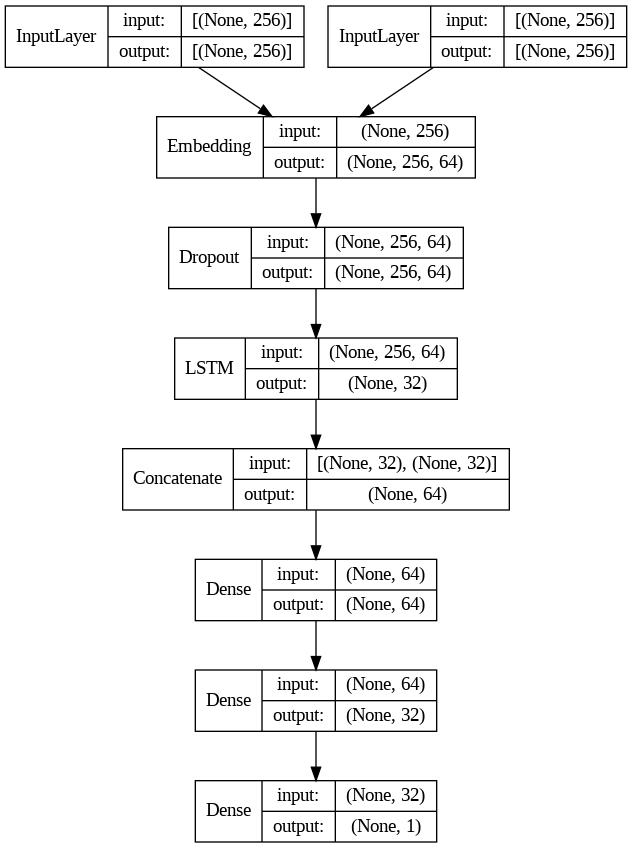

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
# 训练模型
history = model.fit(x=[train_seq_1_np, train_seq_2_np], y=train_labels_np,
          validation_data=([valid_seq_1_np, valid_seq_2_np], valid_labels_np),
          epochs=15, batch_size=64)

Epoch 1/15
289/289 [==============================] - 453s 2s/step - loss: 0.5601 - accuracy: 0.7005 - val_loss: 0.4009 - val_accuracy: 0.8268
Epoch 2/15
289/289 [==============================] - 437s 2s/step - loss: 0.3445 - accuracy: 0.8552 - val_loss: 0.2478 - val_accuracy: 0.8978
Epoch 3/15
289/289 [==============================] - 438s 2s/step - loss: 0.2621 - accuracy: 0.8938 - val_loss: 0.2273 - val_accuracy: 0.9129
Epoch 4/15
289/289 [==============================] - 434s 2s/step - loss: 0.2270 - accuracy: 0.9109 - val_loss: 0.1990 - val_accuracy: 0.9316
Epoch 5/15
289/289 [==============================] - 434s 1s/step - loss: 0.1990 - accuracy: 0.9253 - val_loss: 0.1871 - val_accuracy: 0.9359
Epoch 6/15
289/289 [==============================] - 436s 2s/step - loss: 0.1886 - accuracy: 0.9278 - val_loss: 0.1865 - val_accuracy: 0.9320
Epoch 7/15
289/289 [==============================] - 434s 2s/step - loss: 0.1699 - accuracy: 0.9355 - val_loss: 0.1860 - val_accuracy: 0.9385

In [13]:
loss, accuracy = model.evaluate([test_seq_1_np, test_seq_2_np], test_labels_np)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

73/73 [==============================] - 13s 183ms/step - loss: 0.1585 - accuracy: 0.9506
Test Loss: 0.1585349589586258
Test Accuracy: 0.9506279826164246


73/73 [==============================] - 14s 187ms/step


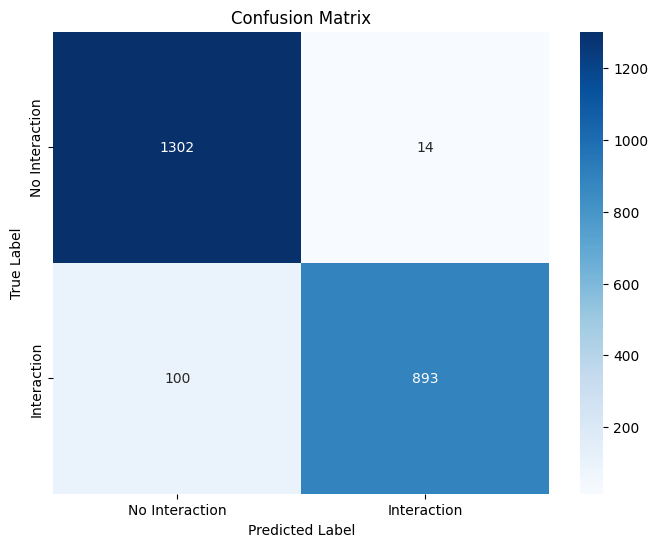

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 预测测试集数据
predictions = model.predict([test_seq_1_np, test_seq_2_np])
predictions = (predictions > 0.5)  # 将概率值转换为二进制预测结果

# 计算混淆矩阵
cm = confusion_matrix(test_labels_np, predictions)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Interaction', 'Interaction'],
            yticklabels=['No Interaction', 'Interaction'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# 预测测试集
test_pred = model.predict([test_seq_1_np, test_seq_2_np])
test_pred = np.round(test_pred)

# 获取测试集真实标签
test_labels = test_labels_np

# 生成混淆矩阵和其他指标
conf_matrix = confusion_matrix(test_labels, test_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(test_labels, test_pred))

73/73 [==============================] - 14s 186ms/step
Confusion Matrix:
[[1302   14]
 [ 100  893]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1316
           1       0.98      0.90      0.94       993

    accuracy                           0.95      2309
   macro avg       0.96      0.94      0.95      2309
weighted avg       0.95      0.95      0.95      2309



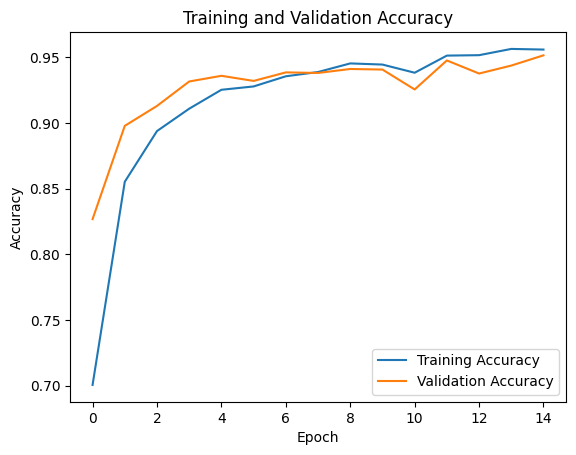

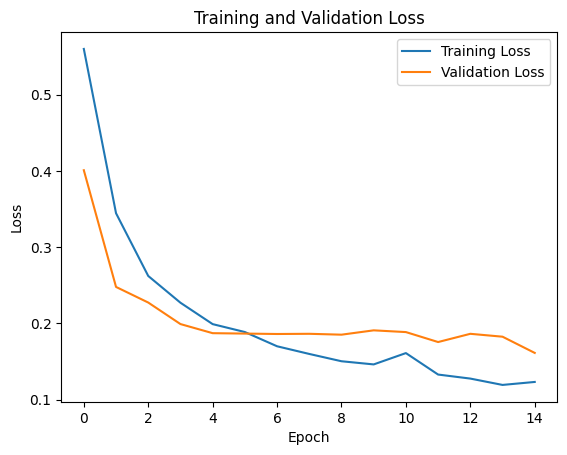

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 绘制损失随epoch变化的图
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()